# Imports

In [1]:
import os
import torchvision
from torchvision import models,transforms,datasets
import torch.nn as nn

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


from torch.autograd import Variable


import torch
import bcolz
import time
%matplotlib inline

In [ ]:
!pip install bcolz

In [2]:
import imp
import utils; imp.reload(utils)
from utils import *

GPU test

In [3]:
use_gpu = torch.cuda.is_available()
print('Using gpu: %s ' % use_gpu)

Using gpu: True 


In [ ]:
a = torch.tensor(2)
a.cuda()

In [ ]:
use_gpu =  False

# Data process

In [4]:
# data_dir = 'D:\\Tu Beo\\Education\\FoodVisor\\data\\UPMC_Food101\\images'
data_dir = '/home/foodlovers/FoodVisor/data/images'

In [5]:
dsets = {x: datasets.ImageFolder(os.path.join(data_dir, x), prep2)
         for x in ['train', 'test']}

In [6]:
len(dsets['train'].classes)

101

In [7]:
dsets['train'].class_to_idx

{'apple_pie': 0,
 'baby_back_ribs': 1,
 'baklava': 2,
 'beef_carpaccio': 3,
 'beef_tartare': 4,
 'beet_salad': 5,
 'beignets': 6,
 'bibimbap': 7,
 'bread_pudding': 8,
 'breakfast_burrito': 9,
 'bruschetta': 10,
 'caesar_salad': 11,
 'cannoli': 12,
 'caprese_salad': 13,
 'carrot_cake': 14,
 'ceviche': 15,
 'cheese_plate': 16,
 'cheesecake': 17,
 'chicken_curry': 18,
 'chicken_quesadilla': 19,
 'chicken_wings': 20,
 'chocolate_cake': 21,
 'chocolate_mousse': 22,
 'churros': 23,
 'clam_chowder': 24,
 'club_sandwich': 25,
 'crab_cakes': 26,
 'creme_brulee': 27,
 'croque_madame': 28,
 'cup_cakes': 29,
 'deviled_eggs': 30,
 'donuts': 31,
 'dumplings': 32,
 'edamame': 33,
 'eggs_benedict': 34,
 'escargots': 35,
 'falafel': 36,
 'filet_mignon': 37,
 'fish_and_chips': 38,
 'foie_gras': 39,
 'french_fries': 40,
 'french_onion_soup': 41,
 'french_toast': 42,
 'fried_calamari': 43,
 'fried_rice': 44,
 'frozen_yogurt': 45,
 'garlic_bread': 46,
 'gnocchi': 47,
 'greek_salad': 48,
 'grilled_cheese_sa

In [8]:
dsets['train'].imgs[:5]

[('/home/foodlovers/FoodVisor/data/images/train/apple_pie/apple_pie_0.jpg', 0),
 ('/home/foodlovers/FoodVisor/data/images/train/apple_pie/apple_pie_100.jpg',
  0),
 ('/home/foodlovers/FoodVisor/data/images/train/apple_pie/apple_pie_101.jpg',
  0),
 ('/home/foodlovers/FoodVisor/data/images/train/apple_pie/apple_pie_102.jpg',
  0),
 ('/home/foodlovers/FoodVisor/data/images/train/apple_pie/apple_pie_104.jpg',
  0)]

In [9]:
dset_classes = dsets['train'].classes

In [10]:
dset_sizes = {x: len(dsets[x]) for x in ['train', 'test']}
dset_sizes

{'train': 67988, 'test': 22716}

Dataset loaders

In [11]:
dset_loaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=64,
                                               shuffle=shuffle_valtrain(x), num_workers=6)
                for x in ['train', 'test']}

In [32]:
dataset_valid = torch.utils.data.DataLoader(dsets['test'], batch_size=5, shuffle=True, num_workers=6)

In [33]:
len(dataset_valid)

4544

In [34]:
count = 0
for data in dataset_valid:
    if count == 0:
        inputs_try,labels_try = data
    else:
        break
    count += 1

In [36]:
labels_try

tensor([12, 21, 64, 28, 69])

In [35]:
inputs_try.shape

torch.Size([5, 3, 299, 299])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


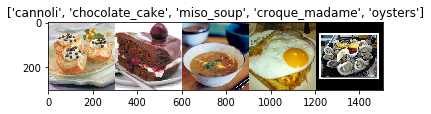

In [37]:
# Make a grid from batch
out = torchvision.utils.make_grid(inputs_try)

imshow(out, title=[dset_classes[x] for x in labels_try])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


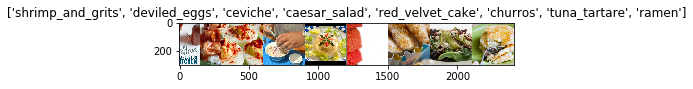

In [38]:
# Get a batch of training data
inputs, classes = next(iter(dset_loaders['train']))

n_images = 8

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[0:n_images])

imshow(out, title=[dset_classes[x] for x in classes[0:n_images]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


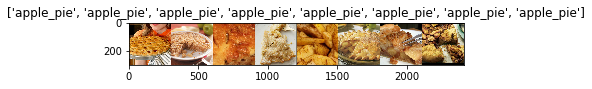

In [39]:
# Get a batch of validation data
inputs, classes = next(iter(dset_loaders['test']))

n_images = 8

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[0:n_images])

imshow(out, title=[dset_classes[x] for x in classes[0:n_images]])

# Creating InceptionV3 Model

In [12]:
model_inception = models.inception_v3(pretrained=True)

In [40]:
inputs_try , labels_try = var_cgpu(inputs_try,use_gpu),var_cgpu(labels_try,use_gpu)

if use_gpu:
    model_inception = model_inception.cuda()

In [49]:
outputs_try,__ = model_inception(inputs_try)

In [44]:
inputs_try.shape

torch.Size([5, 3, 299, 299])

In [50]:
outputs_try

tensor([[-0.2230,  2.0739, -0.5778,  ..., -0.2321,  1.6761, -0.6474],
        [ 0.2218, -0.3957, -0.6131,  ..., -0.8964, -0.2849, -0.9670],
        [ 0.1317, -0.7243,  0.5551,  ...,  0.1682, -0.3799,  0.7765],
        [-0.0037, -1.0820, -0.2419,  ...,  1.0321,  0.8284, -0.1686],
        [-0.8316, -0.3049, -0.2360,  ..., -0.4303, -1.7498,  0.6267]],
       device='cuda:0', grad_fn=<AddmmBackward>)

In [51]:
outputs_try.shape

torch.Size([5, 1000])

### Modifying the last layer and setting the gradient false to all layers

In [13]:
print(model_inception)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [14]:
for param in model_inception.parameters():
    param.requires_grad = False

In [15]:
model_inception.fc = nn.Linear(2048, 101)

In [53]:
model_inception.AuxLogits.fc = nn.Linear(768, 101)

In [16]:
print(model_inception.fc)

Linear(in_features=2048, out_features=101, bias=True)


In [56]:
if use_gpu:
    model_inception = model_inception.cuda()

## Calculating training data

In [20]:
def preconvfeat(dataset):
    conv_features = []
    labels_list = []
    count = 0
    for data in dataset:
        print(count)
        count += 1
        inputs,labels = data
        
        #x = model_vgg.features(inputs)
        conv_features.extend(inputs)
        labels_list.extend(labels)
        if count == 10 :
            break
    #conv_features = np.concatenate([[feat] for feat in conv_features])
    return (conv_features,labels_list)

In [21]:
%%time
conv_feat_train,labels_train = preconvfeat(dset_loaders['train'])

0
1
2
3
4
5
6
7
8
9
CPU times: user 28.7 ms, sys: 133 ms, total: 162 ms
Wall time: 11.8 s


In [28]:
conv_feat_train[0].shape

torch.Size([3, 299, 299])

### Save extracted features

In [ ]:
save_array(data_dir+'/vgg16/conv_feat_train.bc',conv_feat_train)
save_array(data_dir+'/vgg16/labels_train.bc',labels_train)
save_array(data_dir+'/vgg16/conv_feat_val.bc',conv_feat_val)
save_array(data_dir+'/vgg16/labels_val.bc',labels_val)

### Load extracted features

In [ ]:
conv_feat_train = load_array(data_dir+'\\vgg16\\conv_feat_train.bc')
labels_train = load_array(data_dir+'\\vgg16\\labels_train.bc')
conv_feat_val = load_array(data_dir+'\\vgg16\\conv_feat_val.bc')
labels_val = load_array(data_dir+'\\vgg16\\labels_val.bc')

## Training fully connected module

### Creating loss function and optimizer

In [54]:
criterion = nn.CrossEntropyLoss()
lr = 0.01
optimizer_vgg = torch.optim.SGD(model_inception.fc.parameters(),lr = lr)

### Creating Data generator

In [30]:
def data_gen(conv_feat,labels,batch_size=64,shuffle=True):
    labels = np.array(labels)
    if shuffle:
        index = np.random.permutation(len(conv_feat))
        conv_feat = conv_feat[index]
        labels = labels[index]
    for idx in range(0,len(conv_feat),batch_size):
        yield(conv_feat[idx:idx+batch_size],labels[idx:idx+batch_size])

### Training the model

In [40]:
def train_model(model,size,conv_feat=None,labels=None,epochs=1,optimizer=None,train=True,shuffle=True):
    loss_history = []
    acc_history = []
    
    if train:
        model.train()
    else:
        model.eval()
        
    for epoch in range(epochs):
        # batches = data_gen(conv_feat=conv_feat,labels=labels,shuffle=shuffle)
        
        total = 0
        running_loss = 0.0
        running_corrects = 0
        
        for i, data in enumerate(dset_loaders['train'], 0):
        # get the inputs
            inputs, classes = data
            
            if use_gpu:
                inputs , classes = torch.from_numpy(inputs).cuda(), torch.from_numpy(classes).cuda()
            else:
                inputs , classes = torch.from_numpy(inputs), torch.from_numpy(classes)
                
            inputs = inputs.view(inputs.size(0), -1)
            outputs = model(inputs)
            loss = criterion(outputs,classes)           
            if train:
                if optimizer is None:
                    raise ValueError('Pass optimizer for train mode')
                optimizer = optimizer
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            _,preds = torch.max(outputs.data,1)
            # statistics
            running_loss += loss.data.item()
            running_corrects += torch.sum(preds == classes.data)
        epoch_loss = running_loss / size
        epoch_acc = running_corrects.data.item() / size
        print('Loss: {:.4f} Acc: {:.4f}'.format(
                     epoch_loss, epoch_acc))
        
        loss_history.append(epoch_loss)
        acc_history.append(epoch_acc)
        
    return loss_history,acc_history
    

In [33]:
%%time
losses_hist, acc_hist = train_model(model=model_inception,size=dset_sizes['train'],conv_feat=conv_feat_train,labels=labels_train,
            epochs=10,optimizer=optimizer_vgg,train=True,shuffle=False)

TypeError: expected np.ndarray (got list)

In [57]:
for epoch in range(10):
    print("Epoch:", epoch,"===============================================")

    total = 0
    running_loss = 0.0
    running_corrects = 0

    cb = 0
    for i, data in enumerate(dset_loaders['train'], 0):
        cb += 1
        # get the inputs
        inputs, classes = data

        if use_gpu:
            inputs , classes = inputs.cuda(), classes.cuda()
        
        outputs, aux_outputs = model_inception(inputs)
        loss = criterion(outputs,classes) + criterion(aux_outputs,classes)         

        optimizer_vgg.zero_grad()
        loss.backward()
        optimizer_vgg.step()

        _,preds = torch.max(outputs.data,1)
        # statistics
        batch_loss = loss.data.item()
        batch_corrects = torch.sum(preds == classes.data)
        running_loss += batch_loss
        running_corrects += batch_corrects
        
        print('Batch {:d} - Loss: {:.4f} Acc: {:.4f}'.format(cb,
                     batch_loss/64, batch_corrects/64))
        
    epoch_loss = running_loss / dset_sizes['train']
    epoch_acc = running_corrects.data.item() / dset_sizes['train']
    print('Loss: {:.4f} Acc: {:.4f}'.format(
                     epoch_loss, epoch_acc))

Epoch: 0 ===============================================
Batch 1 - Loss: 0.1453 Acc: 0.0000
Batch 2 - Loss: 0.1460 Acc: 0.0000
Batch 3 - Loss: 0.1449 Acc: 0.0000
Batch 4 - Loss: 0.1449 Acc: 0.0000
Batch 5 - Loss: 0.1454 Acc: 0.0000
Batch 6 - Loss: 0.1470 Acc: 0.0000
Batch 7 - Loss: 0.1462 Acc: 0.0000
Batch 8 - Loss: 0.1444 Acc: 0.0000
Batch 9 - Loss: 0.1454 Acc: 0.0000
Batch 10 - Loss: 0.1448 Acc: 0.0000
Batch 11 - Loss: 0.1452 Acc: 0.0000
Batch 12 - Loss: 0.1446 Acc: 0.0000
Batch 13 - Loss: 0.1435 Acc: 0.0000
Batch 14 - Loss: 0.1453 Acc: 0.0000
Batch 15 - Loss: 0.1457 Acc: 0.0000
Batch 16 - Loss: 0.1462 Acc: 0.0000
Batch 17 - Loss: 0.1462 Acc: 0.0000
Batch 18 - Loss: 0.1458 Acc: 0.0000
Batch 19 - Loss: 0.1446 Acc: 0.0000
Batch 20 - Loss: 0.1434 Acc: 0.0000
Batch 21 - Loss: 0.1442 Acc: 0.0000
Batch 22 - Loss: 0.1441 Acc: 0.0000
Batch 23 - Loss: 0.1445 Acc: 0.0000
Batch 24 - Loss: 0.1455 Acc: 0.0000
Batch 25 - Loss: 0.1450 Acc: 0.0000
Batch 26 - Loss: 0.1457 Acc: 0.0000
Batch 27 - Loss:

Batch 224 - Loss: 0.1436 Acc: 0.0000
Batch 225 - Loss: 0.1425 Acc: 0.0000
Batch 226 - Loss: 0.1446 Acc: 0.0000
Batch 227 - Loss: 0.1437 Acc: 0.0000
Batch 228 - Loss: 0.1427 Acc: 0.0000
Batch 229 - Loss: 0.1426 Acc: 0.0000
Batch 230 - Loss: 0.1445 Acc: 0.0000
Batch 231 - Loss: 0.1428 Acc: 0.0000
Batch 232 - Loss: 0.1440 Acc: 0.0000
Batch 233 - Loss: 0.1459 Acc: 0.0000
Batch 234 - Loss: 0.1439 Acc: 0.0000
Batch 235 - Loss: 0.1432 Acc: 0.0000
Batch 236 - Loss: 0.1433 Acc: 0.0000
Batch 237 - Loss: 0.1431 Acc: 0.0000
Batch 238 - Loss: 0.1414 Acc: 0.0000
Batch 239 - Loss: 0.1427 Acc: 0.0000
Batch 240 - Loss: 0.1442 Acc: 0.0000
Batch 241 - Loss: 0.1438 Acc: 0.0000
Batch 242 - Loss: 0.1409 Acc: 0.0000
Batch 243 - Loss: 0.1418 Acc: 0.0000
Batch 244 - Loss: 0.1422 Acc: 0.0000
Batch 245 - Loss: 0.1433 Acc: 0.0000
Batch 246 - Loss: 0.1443 Acc: 0.0000
Batch 247 - Loss: 0.1411 Acc: 0.0000
Batch 248 - Loss: 0.1416 Acc: 0.0000
Batch 249 - Loss: 0.1442 Acc: 0.0000
Batch 250 - Loss: 0.1427 Acc: 0.0000
B

Traceback (most recent call last):
  File "/home/foodlovers/miniconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/foodlovers/miniconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/foodlovers/miniconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
Traceback (most recent call last):
  File "/home/foodlovers/miniconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/foodlovers/miniconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/foodlovers/miniconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/foodlovers/miniconda3/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self.

KeyboardInterrupt: 

In [50]:
for i, data in enumerate(dset_loaders['train'], 0):
    # get the inputs
        inputs, classes = data
        
        inputs = inputs.cuda()
        classes = classes.cuda()
        
        outputs,_ = model_inception(inputs)
        
        _,preds = torch.max(outputs.data,1)
        
        print(preds)
        
        break

tensor([70, 83, 30, 92,  0, 92, 94, 15, 77, 92, 69, 95, 49, 49, 95, 21, 52,  3,
        14, 92, 26, 77, 49, 49, 65, 30, 36, 79, 21, 15, 50, 23, 52, 81, 92, 92,
        52, 99, 77,  5, 49, 79, 52, 65, 73,  7, 24,  7, 81,  9, 87, 72, 52, 92,
        30, 80, 65, 49, 31, 79, 20, 16, 96, 80], device='cuda:0')


Validation

In [ ]:
train_model(conv_feat=conv_feat_val,labels=labels_val,model=model_vgg.classifier
            ,size=dset_sizes['test'],train=False,shuffle=False)

Plot loss & accuracy history

In [ ]:
plt.plot(losses_hist)
plt.title("Loss history")

In [ ]:
plt.plot(acc_hist)
plt.title("Training accuracy history")

### Some wrong images

In [ ]:
m_softm = nn.Softmax(dim=1)

In [ ]:
count = 0
test_set_loader = torch.utils.data.DataLoader(dsets['test'], batch_size=dset_sizes['test'],
                                               shuffle=False, num_workers=0)
test_imgs, __ = next(iter(test_set_loader))

for i in range(dset_sizes['test']):
    feat_val = torch.from_numpy(conv_feat_val[i]).view(1,-1)
    label_val = labels_val[i]
    
    _,pred = torch.max(m_softm(model_vgg.classifier(feat_val).data),1)
    
    predicted = pred.data.cpu().numpy()[0]
    
    if predicted != label_val:
        #print(dsets['test'].imgs[i])
        out = torchvision.utils.make_grid(test_imgs[i])
        imshow(out, title=dsets['test'].imgs[i])
        count += 1
    #if count == 20:
    #    break